<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/papers/Artigo%201/V1/Vers%C3%A3o_1_(treino_80_e_teste_20_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine learning for predicting liver and/or lung metastasis in colorectal cancer: A retrospective study based on the SEER database***

Este estudo propõe um modelo de aprendizado de máquina para prever o risco de metástase hepática e/ou pulmonar em pacientes com câncer colorretal (CRC). A partir da base de dados SEER, foram extraídos dados aproximadamente 53 mil pacientes com diagnóstico patológico de CRC entre 2010 e 2015, desenvolvendo sete modelos de algoritmos(Decision tree, Randon Forest, Naive Bayes,  KNN,XGBoost, Gradient Boosting.

## 1. Importação das Bibliotecas

Todas as ferramentas necessárias para manipulação de dados, balanceamento de classes, construção de modelos e visualização de resultados são importadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.exceptions import NotFittedError

## 2. Carregamento e Pré-processamento dos Dados

* O dataset, que inclui informações clínicas e demográficas de pacientes com
câncer colorretal, é carregado de um arquivo CSV.
* As variáveis preditoras incluem características como idade, sexo, tipo histológico, tamanho do tumor e outros fatores clínicos importantes.
* A variável alvo indica se o paciente apresenta metástase no fígado ou pulmão.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')

# Verificar e remover valores faltantes
df.dropna(inplace=True)

# Definir variáveis preditoras (X) e alvo (y)
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis',
        'Origin recode NHIA (Hispanic, Non-Hisp)']]

# Variável alvo: combinação de metástase hepática e pulmonar
y = (df['SEER Combined Mets at DX-liver (2010+)'] == 'Yes') | \
    (df['SEER Combined Mets at DX-lung (2010+)'] == 'Yes')
y = y.astype(int)  # Converter para binário

# Codificação de variáveis categóricas
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])


<ipython-input-2-45100147752f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-45100147752f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-45100147752f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## 3. Escalonamento e Balanceamento dos Dados

Para lidar com o desbalanceamento entre classes (pacientes com e sem metástases), técnicas de balanceamento como SMOTE (para aumentar as amostras da classe minoritária) e undersampling (para reduzir a classe majoritária) são aplicadas.
Os dados são escalados para garantir que as variáveis sejam comparáveis em magnitude.

In [3]:
# Divisão dos dados em treino e teste
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalonamento dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

#BALANCEAMENTO DOS DADOS
# Aplicar undersampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train_scaled, y_train_full)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_full)

## 4. Definição dos Modelos

* Diversos modelos de aprendizado de máquina são configurados, incluindo Random Forest, SVM, Naive Bayes, Gradient Boosting, e outros.
* Esses modelos são treinados em dados balanceados para garantir previsões justas e reduzir o risco de overfitting.

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

## 5. Geração e Visualização das Curvas ROC

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:10:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-7-150a2c66e52f>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Aleatório")


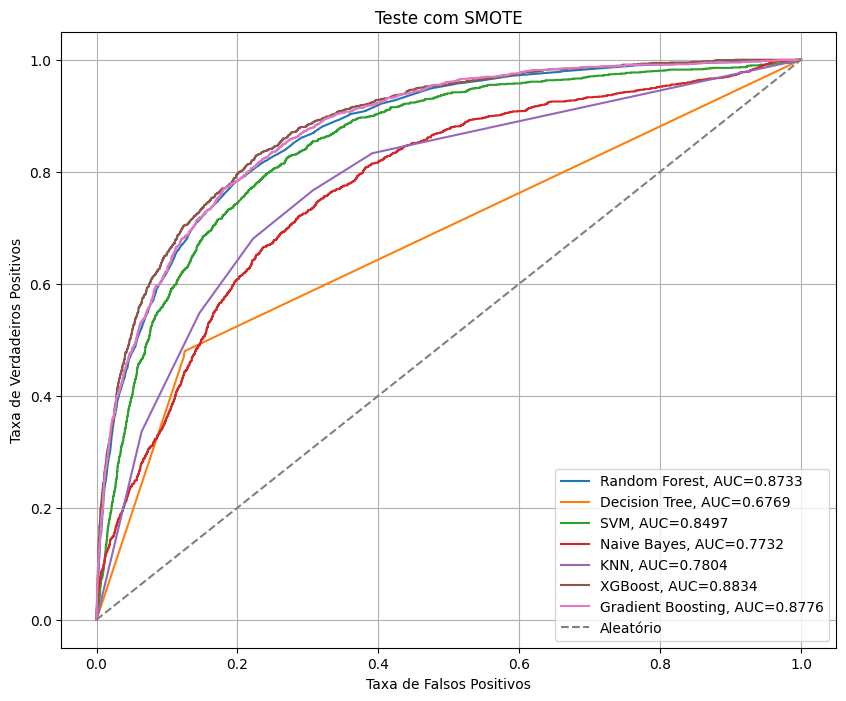

<ipython-input-7-150a2c66e52f>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Aleatório")


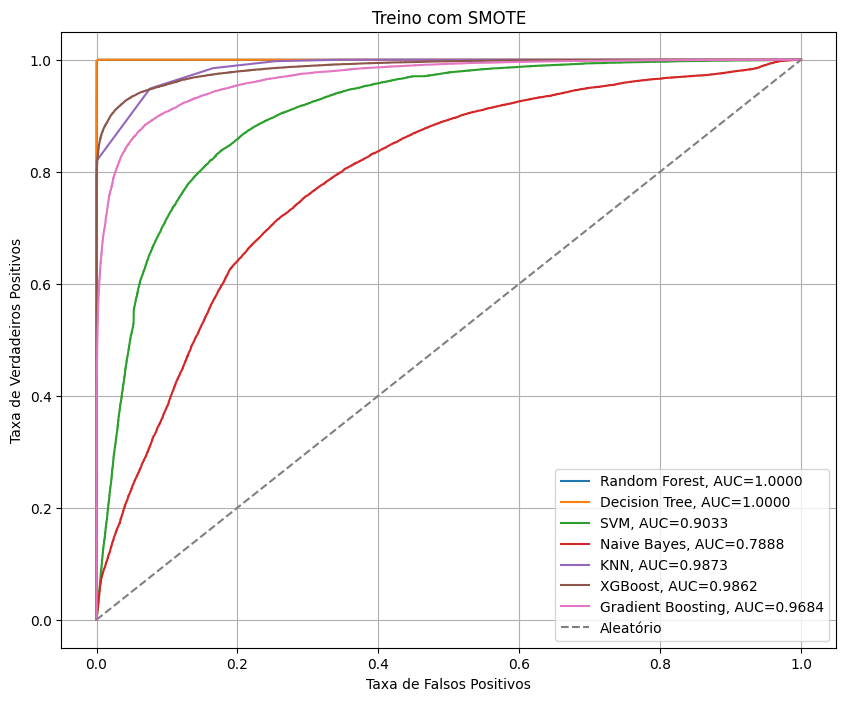

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:15:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-7-150a2c66e52f>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Aleatório")


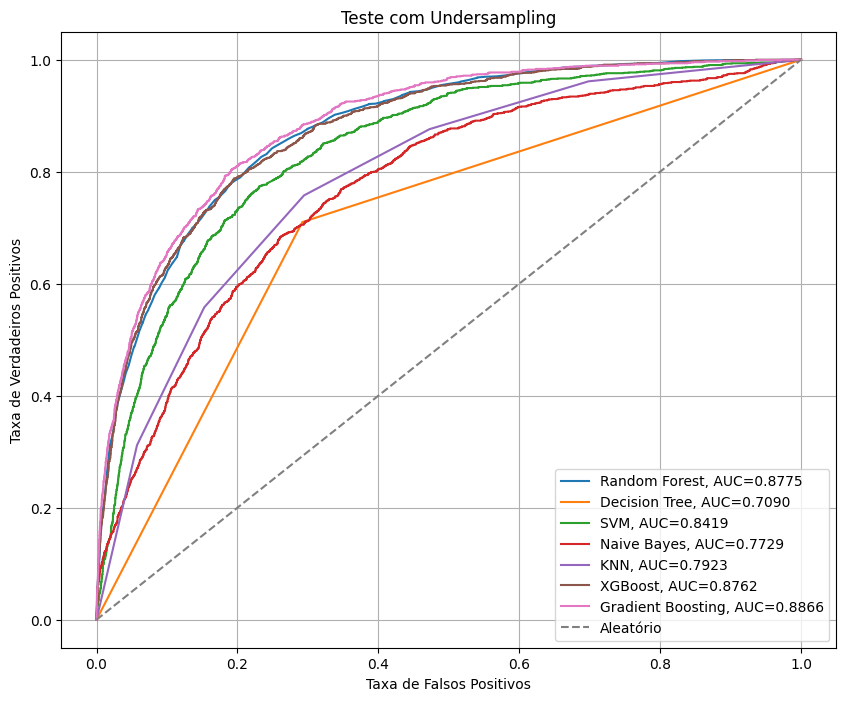

<ipython-input-7-150a2c66e52f>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Aleatório")


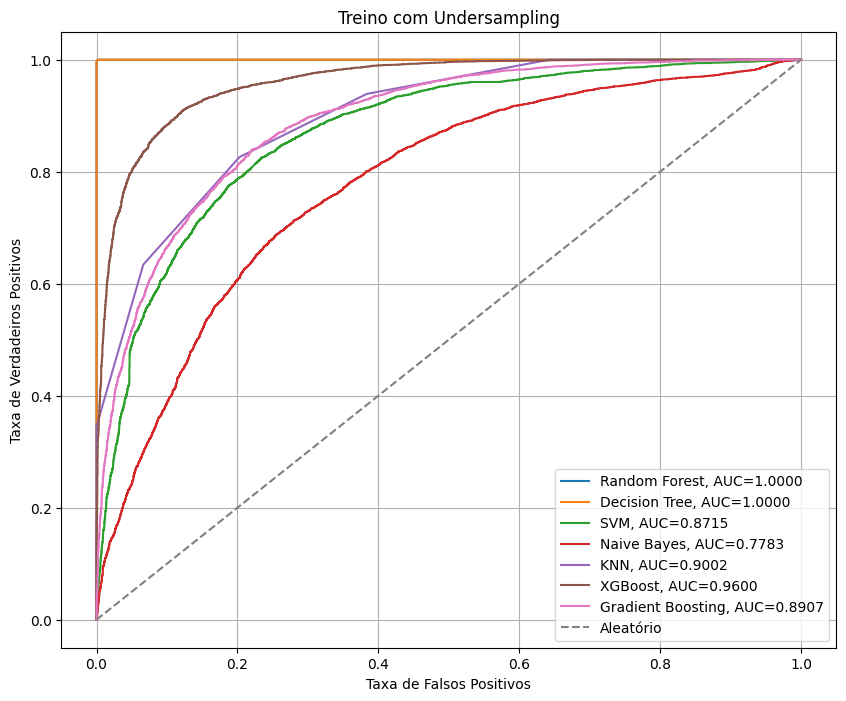

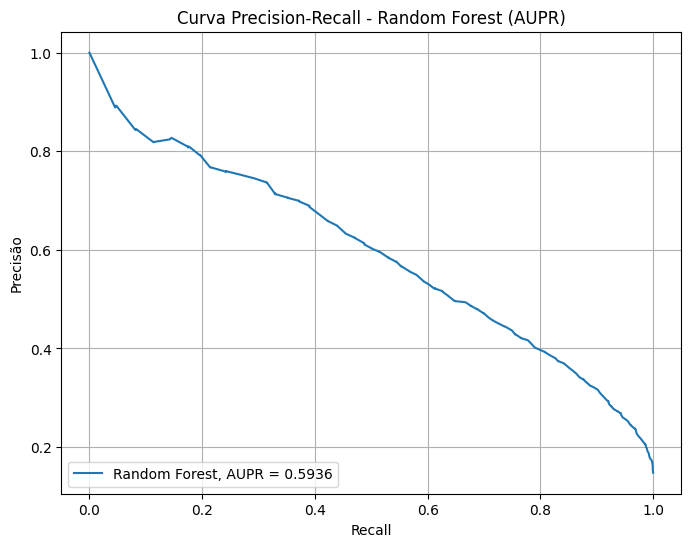


Tabela de Resultados:
            Model  Accuracy   AUC  Precision  Recall  F1-score
    Random Forest     0.786 0.878      0.392   0.808     0.528
    Decision Tree     0.708 0.709      0.297   0.710     0.419
              SVM     0.754 0.842      0.351   0.786     0.485
      Naive Bayes     0.718 0.773      0.303   0.693     0.421
              KNN     0.713 0.792      0.309   0.758     0.439
          XGBoost     0.784 0.876      0.389   0.806     0.524
Gradient Boosting     0.795 0.887      0.405   0.817     0.541


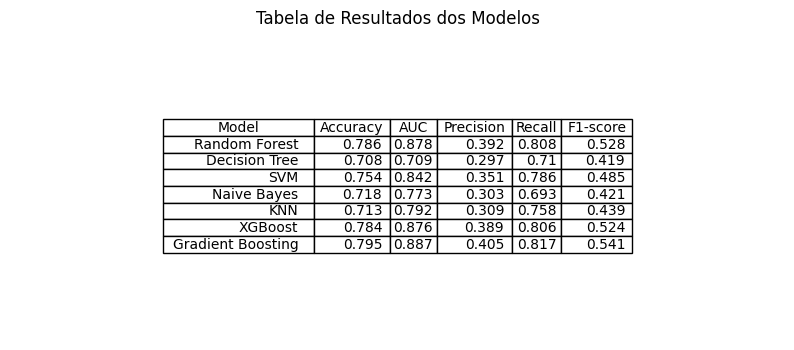

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc

# 1. TREINAMENTO DOS MODELOS (Oversampling com SMOTE)
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)

# Função para plotar as curvas ROC
def plot_roc_curves(models, X_train, y_train, X_test, y_test, title, output_file=None):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        # Previsões no conjunto de teste
        y_test_proba = model.predict_proba(X_test)[:, 1]
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
        auc_test = roc_auc_score(y_test, y_test_proba)

        # Adiciona ao gráfico
        plt.plot(fpr_test, tpr_test, label=f"{model_name}, AUC={auc_test:.4f}")

    # Adiciona linha diagonal (classificação aleatória)
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label="Aleatório")

    # Personalização do gráfico
    plt.title(title)
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.grid()

    # Salvar ou exibir
    if output_file:
        plt.savefig(output_file, dpi=300)
    else:
        plt.show()

# 2. GERAÇÃO DOS GRÁFICOS (Oversampling)
plot_roc_curves(models, X_train_smote, y_train_smote, X_test_scaled, y_test, "Teste com SMOTE")
plot_roc_curves(models, X_train_smote, y_train_smote, X_train_smote, y_train_smote, "Treino com SMOTE")

# 3. TREINAMENTO DOS MODELOS (Undersampling)
for model_name, model in models.items():
    model.fit(X_train_under, y_train_under)

# Geração dos gráficos (Undersampling)
plot_roc_curves(models, X_train_under, y_train_under, X_test_scaled, y_test, "Teste com Undersampling")
plot_roc_curves(models, X_train_under, y_train_under, X_train_under, y_train_under, "Treino com Undersampling")

# 4. CURVA PRECISION-RECALL PARA RANDOM FOREST
# Verificar se o modelo Random Forest foi treinado e está disponível
if "Random Forest" in models:
    rf_model = models["Random Forest"]
    precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
    aupr_rf = auc(recall_rf, precision_rf)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_rf, precision_rf, label=f"Random Forest, AUPR = {aupr_rf:.4f}")
    plt.title("Curva Precision-Recall - Random Forest (AUPR)")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# 5. AVALIAÇÃO DOS MODELOS E GERAÇÃO DA TABELA
# Inicializar um dicionário para armazenar os resultados
results = {
    "Model": [],
    "Accuracy": [],
    "AUC": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# Avaliação dos modelos nos dados de teste
for model_name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Cálculo das métricas
    accuracy = accuracy_score(y_test, y_test_pred)
    auc_score = roc_auc_score(y_test, y_test_proba)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Adicionar os resultados ao dicionário
    results["Model"].append(model_name)
    results["Accuracy"].append(round(accuracy, 3))
    results["AUC"].append(round(auc_score, 3))
    results["Precision"].append(round(precision, 3))
    results["Recall"].append(round(recall, 3))
    results["F1-score"].append(round(f1, 3))

# Criar um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibir a tabela no console
print("\nTabela de Resultados:")
print(df_results.to_string(index=False))

# Opcional: Salvar a tabela como CSV
df_results.to_csv("model_performance_results.csv", index=False)

# Gerar uma tabela como imagem
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df_results.columns))))

# Salvar ou exibir a tabela como imagem
plt.title("Tabela de Resultados dos Modelos")
plt.savefig("model_performance_table.png", dpi=300)
plt.show()


6. GRAFICO DE IMPORTÂNCIA DAS VARIÁVEIS (RANDOM FOREST)

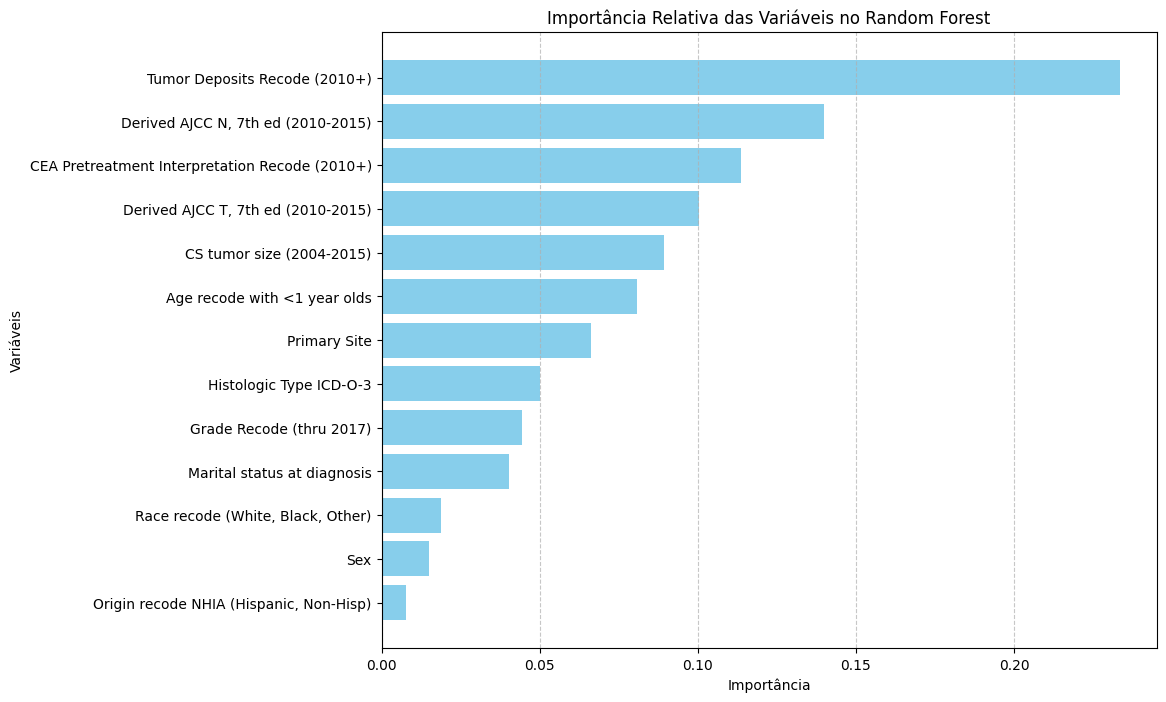

In [ ]:
# Treinar o modelo Random Forest no conjunto balanceado com SMOTE
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Importância das variáveis
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Criar DataFrame para organizar
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Plotar o gráfico de barras horizontais
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância Relativa das Variáveis no Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

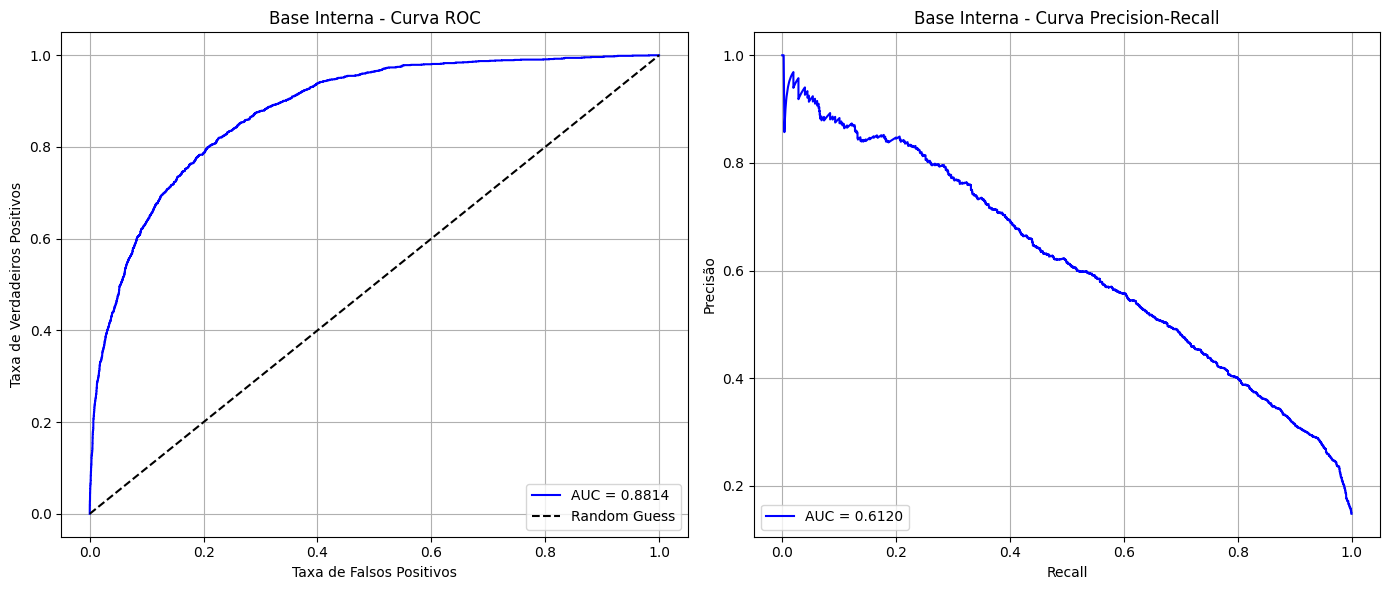

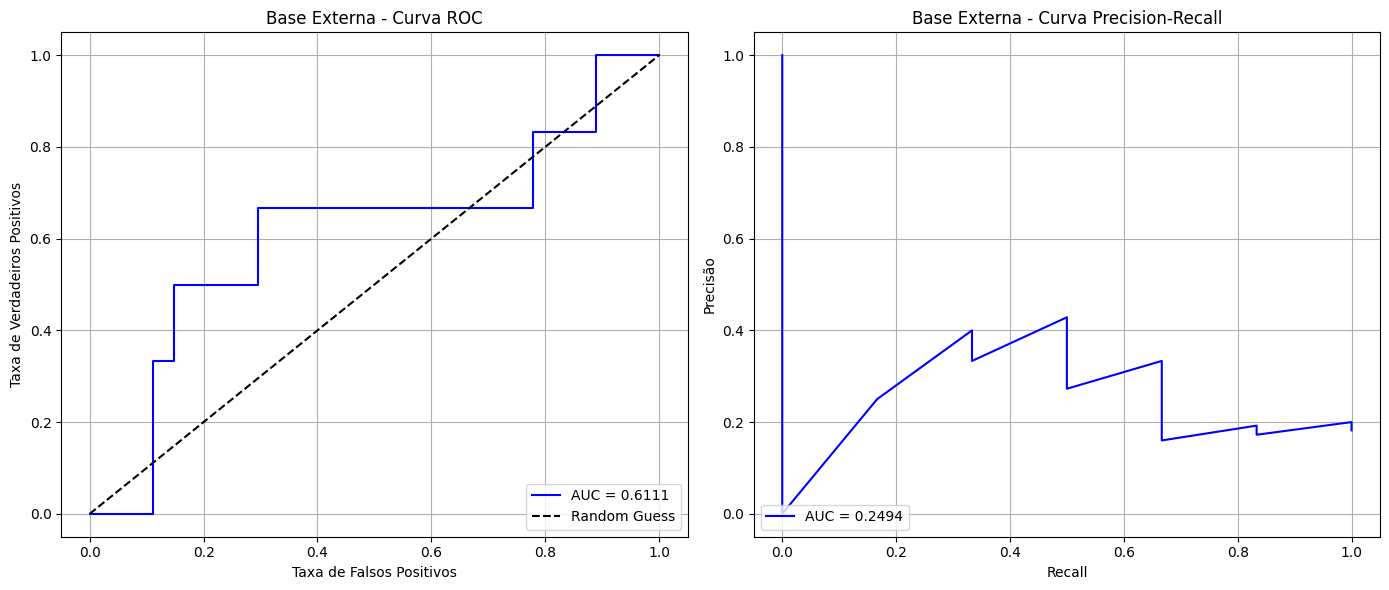

In [6]:
# Ajustando hiperparâmetros do modelo Random Forest
rf_model_ext = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5, random_state=42
)
rf_model_ext.fit(X_train_ext_scaled, y_train_ext)

# Reutilizando o modelo interno
rf_model_int = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5, random_state=42
)
rf_model_int.fit(X_train_smote, y_train_smote)

# Função para plotagem refinada
def plot_pr_roc_curves(model, X_test, y_test, title_prefix):
    plt.figure(figsize=(14, 6))

    # Probabilidades previstas
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Subplot 1: Curva ROC
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
    plt.title(f"{title_prefix} - Curva ROC")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend(loc="lower right")
    plt.grid()

    # Subplot 2: Precision-Recall
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.4f}", color='blue')
    plt.title(f"{title_prefix} - Curva Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.legend(loc="lower left")
    plt.grid()

    # Exibir gráficos
    plt.tight_layout()
    plt.show()

# Gerar gráficos para a base interna
plot_pr_roc_curves(rf_model_int, X_test_scaled, y_test, "Base Interna")

# Gerar gráficos para a base externa
plot_pr_roc_curves(rf_model_ext, X_test_ext_scaled, y_test_ext, "Base Externa")
